In [1]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")

import plotly.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go
pyoff.init_notebook_mode(connected=True)

In [2]:
def parser(x):
    return pd.datetime.strptime('190'+x, '%Y-%m')

df = pd.read_csv('shampoo.csv', parse_dates=[0], index_col=0, date_parser=parser)
df.tail()

,Sales
Month,
1903-08-01,407.6
1903-09-01,682.0
1903-10-01,475.3
1903-11-01,581.3
1903-12-01,646.9


In [3]:
train = df

scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)

In [4]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)

In [5]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

In [18]:
history = model.fit_generator(generator,epochs=100,verbose=1)

Epoch 1/100
4/4 [==============================] - 0s 74ms/step - loss: 0.0098
Epoch 2/100
4/4 [==============================] - 0s 88ms/step - loss: 0.0118
Epoch 3/100
4/4 [==============================] - 0s 76ms/step - loss: 0.0118
Epoch 4/100
4/4 [==============================] - 0s 74ms/step - loss: 0.0092
Epoch 5/100
4/4 [==============================] - ETA: 0s - loss: 0.012 - 0s 80ms/step - loss: 0.0104
Epoch 6/100
4/4 [==============================] - 0s 79ms/step - loss: 0.0054
Epoch 7/100
4/4 [==============================] - 0s 97ms/step - loss: 0.0128
Epoch 8/100
4/4 [==============================] - 0s 77ms/step - loss: 0.0090
Epoch 9/100
4/4 [==============================] - ETA: 0s - loss: 0.009 - 0s 99ms/step - loss: 0.0081
Epoch 10/100
4/4 [==============================] - 0s 77ms/step - loss: 0.0091
Epoch 11/100
4/4 [==============================] - 0s 97ms/step - loss: 0.0091
Epoch 12/100
4/4 [==============================] - 0s 78ms/step - loss: 0.0081
E

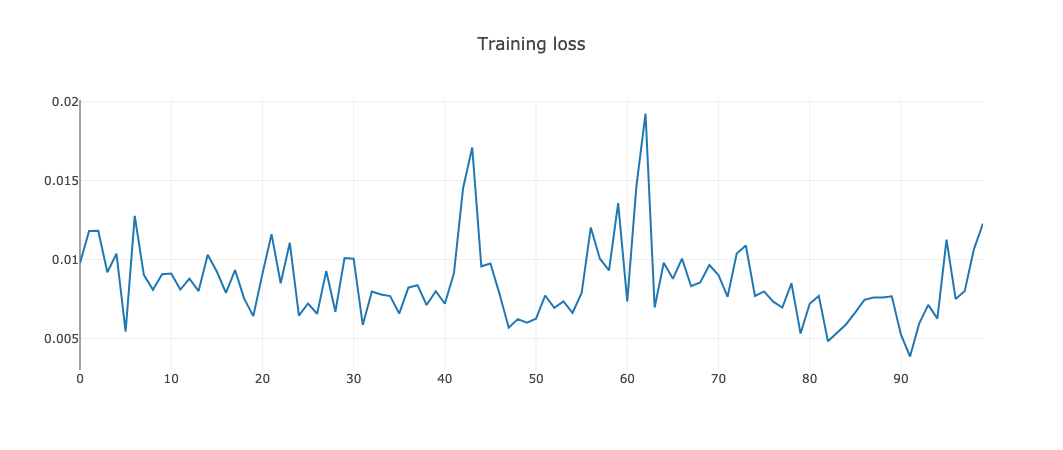

In [19]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plot_data = [
    go.Scatter(
        x=hist['epoch'],
        y=hist['loss'],
        name='loss'
    )
    
]

plot_layout = go.Layout(
        title='Training loss'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [20]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [21]:
add_dates = [df.index[-1] + DateOffset(months=x) for x in range(0,13) ]
future_dates = pd.DataFrame(index=add_dates[1:],columns=df.columns)

In [22]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=future_dates[-n_input:].index, columns=['Prediction'])

df_proj = pd.concat([df,df_predict], axis=1)

df_proj.tail(12)

,Sales,Prediction
1904-01-01,NaN,632.236153
1904-02-01,NaN,575.939878
1904-03-01,NaN,723.731967
1904-04-01,NaN,663.357184
1904-05-01,NaN,829.291679
1904-06-01,NaN,889.739176
1904-07-01,NaN,962.319598
1904-08-01,NaN,1117.373399
1904-09-01,NaN,1080.341729
1904-10-01,NaN,1258.043234


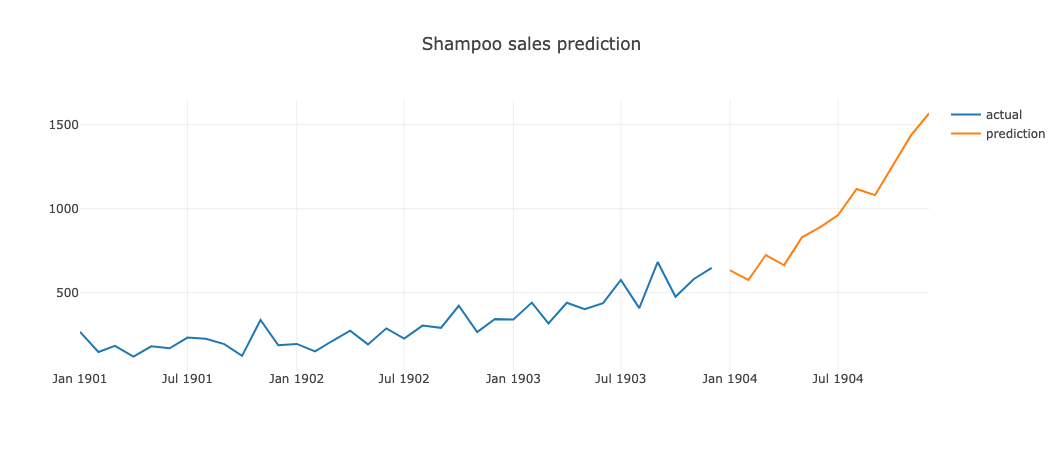

In [23]:
plot_data = [
    go.Scatter(
        x=df_proj.index,
        y=df_proj['Sales'],
        name='actual'
    ),
    go.Scatter(
        x=df_proj.index,
        y=df_proj['Prediction'],
        name='prediction'
    )
]

plot_layout = go.Layout(
        title='Shampoo sales prediction'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)